# Extracción de caracteristicas proyecto:
# Clasificación de supernovas de ALeRCE - ZTF
### Por Joaquin Zepeda y Benjamin Irarrazabal - Tutor: Pablo Montero

In [ ]:
# pyarrow might be needed to read the data
!python -m pip install Cython
!python -m pip install -e git+https://git@github.com/alercebroker/turbo-fats#egg=turbofats
!python -m pip install -e git+https://git@github.com/alercebroker/mhps#egg=mhps
!python -m pip install -e git+https://git@github.com/alercebroker/P4J#egg=P4J
!python -m pip install pyarrow
!python -m pip install -e git+https://git@github.com/alercebroker/lc_classifier#egg=lc_classifier

Obtaining turbofats from git+https://****@github.com/alercebroker/turbo-fats#egg=turbofats
  Cloning https://****@github.com/alercebroker/turbo-fats to ./src/turbofats
  Running command git clone -q 'https://****@github.com/alercebroker/turbo-fats' /content/src/turbofats
  Running setup.py develop for turbofats
Obtaining mhps from git+https://****@github.com/alercebroker/mhps#egg=mhps
  Cloning https://****@github.com/alercebroker/mhps to ./src/mhps
  Running command git clone -q 'https://****@github.com/alercebroker/mhps' /content/src/mhps
  Running setup.py develop for mhps
Obtaining P4J from git+https://****@github.com/alercebroker/P4J#egg=P4J
  Cloning https://****@github.com/alercebroker/P4J to ./src/p4j
  Running command git clone -q 'https://****@github.com/alercebroker/P4J' /content/src/p4j
  Running setup.py develop for P4J
Obtaining lc_classifier from git+https://****@github.com/alercebroker/lc_classifier#egg=lc_classifier
  Cloning https://****@github.com/alercebroker/lc_cla

In [ ]:
import numpy as np
import pandas as pd
from lc_classifier.features import ZTFLightcurvePreprocessor, ZTFFeatureExtractor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Importamos los extractores de caracteristicas

In [ ]:
from lc_classifier.features import SupernovaeDetectionFeatureExtractor, SNParametricModelExtractor, IQRExtractor,MHPSExtractor,PeriodExtractor

# Leyendo los datos
La idea es seleccionar los dos archivos CSV que contienen los datos: 

1- detections_SNe_v7.0.1.csv

2- dfcrossmatches_prioritized_v7.0.1.csv

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving detections_SNe_v7.0.1.csv to detections_SNe_v7.0.1 (1).csv
Saving dfcrossmatches_prioritized_v7.0.1.csv to dfcrossmatches_prioritized_v7.0.1 (1).csv


In [ ]:
import io
detections = pd.read_csv(io.StringIO(uploaded['detections_SNe_v7.0.1.csv'].decode('utf-8')), index_col=None)
dfcrossmatches = pd.read_csv(io.StringIO(uploaded['dfcrossmatches_prioritized_v7.0.1.csv'].decode('utf-8')), index_col=None)

In [ ]:
detections.head()

,Unnamed: 0,objectId,fid,isdiffpos,sigmapsf,field,fwhm,dec,magpsf,rcid,ra,sky,rb,ssmagnr,distpsnr3,sgscore2,maggaiabright,distpsnr2,distpsnr1,maggaia,exptime,drb,sgscore3,neargaia,sgscore1,mjd,corrected,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,dubious,has_stamp
0,0,ZTF18aahvndq,1,1.0,0.028791,626,3.59,27.008621,15.385100,34,198.722678,-0.101586,0.770000,-999.0,21.691795,0.001667,-999.0,21.650759,1.984529,17.138538,30.0,0.999970,0.5,78.019280,0.175976,58991.302095,False,NaN,NaN,NaN,False,True
1,1,ZTF18aahvndq,1,1.0,0.031231,626,2.57,27.008635,15.712121,34,198.722679,-0.217021,0.894286,-999.0,21.712288,0.001667,-999.0,21.672073,2.034691,17.138538,30.0,0.999996,0.5,78.022800,0.175976,59000.260914,False,NaN,NaN,NaN,False,True
2,2,ZTF18aahvndq,1,1.0,0.032161,626,1.98,27.008647,16.072975,34,198.722653,-1.455619,0.907143,-999.0,21.647310,0.001667,-999.0,21.608295,2.075565,17.138538,30.0,0.999939,0.5,78.111310,0.175976,59004.192674,False,NaN,NaN,NaN,False,True
3,3,ZTF18aahvndq,1,1.0,0.049931,626,2.75,27.008624,17.708502,34,198.722660,0.167642,0.947143,-999.0,21.641445,0.001667,-999.0,21.600946,1.995552,17.138538,30.0,0.999956,0.5,78.077545,0.175976,59021.227604,False,NaN,NaN,NaN,False,True
4,4,ZTF18aahvndq,1,1.0,0.028520,626,3.13,27.008636,15.617474,34,198.722660,0.027993,0.837143,-999.0,21.656885,0.001667,-999.0,21.617119,2.039114,17.138538,30.0,0.999770,0.5,78.083150,0.175976,58986.223646,False,NaN,NaN,NaN,False,True


In [ ]:
dfcrossmatches.head()

,oid,classALeRCE,ra,dec,period,source,id_source,class_source,separation_arcsec
0,ZTF19abegncu,AGN,357.296363,-8.941186,NaN,Oh2015,5.8772718059579e+17,AGN_galaxy_dominated,0.243081
1,ZTF18acejdhu,AGN,11.958444,-10.496615,NaN,Oh2015,5.877272256953059e+17,AGN_galaxy_dominated,0.301126
2,ZTF18acdzene,AGN,17.478620,-10.110250,NaN,Oh2015,5.877271789938934e+17,AGN_galaxy_dominated,0.158643
3,ZTF18abwzuzw,AGN,25.038255,-10.352430,NaN,Oh2015,5.877272294485526e+17,AGN_galaxy_dominated,0.485322
4,ZTF19abmposz,AGN,26.670031,-8.354787,NaN,Oh2015,5.877271806085038e+17,AGN_galaxy_dominated,0.213990


# Union de tablas
Se realiza un Join con el fin de tener además de los nombres de los objetos, la clase a la cual pertenece, tendremos algunas columnas extras las cuales serán eliminadas más tarde

In [ ]:
Conjunto = pd.merge(detections, dfcrossmatches, left_on='objectId', right_on='oid')

In [ ]:
#'errorpsf','errorpsf_corr'
# Le hacemos un slicing al conjunto:
slice_cjto = Conjunto[['objectId','classALeRCE','isdiffpos','magpsf','mjd','magpsf_corr','sigmapsf','sigmapsf_corr','fid','sigmapsf']]
slice_cjto.set_index("objectId", inplace = True)
slice_cjto.head() # Printeamos las primeras filas del conjunto para observar que se hayan tomado bien los datos

,classALeRCE,isdiffpos,magpsf,mjd,magpsf_corr,sigmapsf,sigmapsf_corr,fid,sigmapsf
objectId,,,,,,,,,
ZTF18aahvndq,SNIa,1.0,15.385100,58991.302095,NaN,0.028791,NaN,1,0.028791
ZTF18aahvndq,SNIa,1.0,15.712121,59000.260914,NaN,0.031231,NaN,1,0.031231
ZTF18aahvndq,SNIa,1.0,16.072975,59004.192674,NaN,0.032161,NaN,1,0.032161
ZTF18aahvndq,SNIa,1.0,17.708502,59021.227604,NaN,0.049931,NaN,1,0.049931
ZTF18aahvndq,SNIa,1.0,15.617474,58986.223646,NaN,0.028520,NaN,1,0.028520


## Eliminar Na

In [ ]:
# Eliminamos las filas NaN de los datos ya que no nos serán útiles para la clasificación:
slice_cjtona = slice_cjto.dropna()

# Deteccion de outliers

In [ ]:
slice_cjtona


,classALeRCE,isdiffpos,magpsf,mjd,magpsf_corr,sigmapsf,sigmapsf_corr,fid,sigmapsf
objectId,,,,,,,,,
ZTF19acyogrm,SNIbc,1.0,18.949500,58839.130984,18.810375,0.217732,0.190439,1,0.217732
ZTF19acyogrm,SNIbc,1.0,21.143200,58876.150220,20.373898,0.407393,0.180825,1,0.407393
ZTF19acyogrm,SNIbc,1.0,20.490700,58862.138264,20.004205,0.204389,0.115048,1,0.204389
ZTF19acyogrm,SNIbc,1.0,20.365100,58871.175810,19.922308,0.226880,0.139607,1,0.226880
ZTF19acyogrm,SNIbc,1.0,21.167200,58876.150220,20.385649,0.417040,0.183085,1,0.417040
...,...,...,...,...,...,...,...,...,...
ZTF19abiietd,SNII,1.0,15.788478,58737.173403,15.249795,0.024005,100.000000,2,0.024005
ZTF19abiietd,SNII,1.0,16.821075,58768.118877,15.757745,0.046151,100.000000,2,0.046151
ZTF19abiietd,SNII,1.0,16.299719,58749.111806,15.531676,0.034687,100.000000,2,0.034687


In [ ]:
from scipy import stats
import numpy as n
#Generalmente se utiliza un zscore: z = (x – μ) / σ
#(x - promedio)/desviacion < umbral, generalmente se ysa que sea menor a 3 desviaciones
clean_data = slice_cjtona[(np.abs(stats.zscore(slice_cjtona['magpsf_corr'])) < 3)]
clean_data


,classALeRCE,isdiffpos,magpsf,mjd,magpsf_corr,sigmapsf,sigmapsf_corr,fid,sigmapsf
objectId,,,,,,,,,
ZTF19acyogrm,SNIbc,1.0,18.949500,58839.130984,18.810375,0.217732,0.190439,1,0.217732
ZTF19acyogrm,SNIbc,1.0,21.143200,58876.150220,20.373898,0.407393,0.180825,1,0.407393
ZTF19acyogrm,SNIbc,1.0,20.490700,58862.138264,20.004205,0.204389,0.115048,1,0.204389
ZTF19acyogrm,SNIbc,1.0,20.365100,58871.175810,19.922308,0.226880,0.139607,1,0.226880
ZTF19acyogrm,SNIbc,1.0,21.167200,58876.150220,20.385649,0.417040,0.183085,1,0.417040
...,...,...,...,...,...,...,...,...,...
ZTF19abiietd,SNII,1.0,15.788478,58737.173403,15.249795,0.024005,100.000000,2,0.024005
ZTF19abiietd,SNII,1.0,16.821075,58768.118877,15.757745,0.046151,100.000000,2,0.046151
ZTF19abiietd,SNII,1.0,16.299719,58749.111806,15.531676,0.034687,100.000000,2,0.034687


# Número por clases

In [ ]:
# tomamos un subslice de los datos tomando solo la columna del Id con la de la clase:
clean_data = clean_data.reset_index()
subslice = clean_data[['objectId','classALeRCE']]
# Ahora, a este subslice, le eliminamos los "duplicados" de cada curva para poder obtener la cantidad de supernovas que tenemos
subslice_sinduplicados = subslice.drop_duplicates(subset=['objectId'])
# Y ahora que ya tenemos esto, podemos calcular la cantidad de supernovas real que hay, es decir, tomando solo 1 muestra para c/u
subslice_sinduplicados.groupby('classALeRCE').count()

,objectId
classALeRCE,
SLSN,24
SNII,198
SNIIb,10
SNIIn,25
SNIa,837
SNIbc,68


# Histograma

<AxesSubplot:xlabel='classALeRCE'>

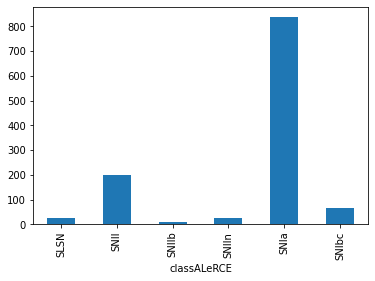

In [ ]:
group_cleandata = subslice_sinduplicados.groupby('classALeRCE')['classALeRCE'].count()
group_cleandata.plot(kind='bar')

# Analisis de componentes principales PCA: algoritmo que nos permite reducir la dimensionalidad de los datos.

              0         1         2  ...             7             8             9
0      2.600527  0.083170 -0.502069  ... -4.690771e-17  5.588769e-17 -1.650875e-17
1      8.687311 -0.827861 -0.420534  ... -6.081288e-16  3.619691e-17 -2.717946e-17
2      3.206148  0.569828 -0.150476  ... -8.875455e-16 -1.256695e-15  5.537725e-16
3      3.702268  0.373611 -0.181999  ...  2.547588e-15  4.563151e-15  2.838289e-16
4      8.943320 -0.895958 -0.436835  ...  5.865270e-14 -6.806189e-16 -6.464360e-18
...         ...       ...       ...  ...           ...           ...           ...
50862 -4.896097 -1.796058  0.231098  ... -1.789080e-17 -1.709768e-17 -4.794707e-19
50863 -3.786012 -1.831244  0.417752  ... -1.970789e-17 -2.606392e-17 -8.711295e-19
50864 -4.345559 -1.797043  0.316692  ...  8.957644e-17 -2.179177e-17 -6.725969e-19
50865 -4.675368 -0.721271 -0.610857  ... -1.776212e-17 -1.453917e-17 -1.166631e-19
50866 -4.765183 -1.968962  0.007534  ...  9.964352e-17  1.757436e-16  1.155445e-17

[50

Text(0, 0.5, 'Second Principal Component')

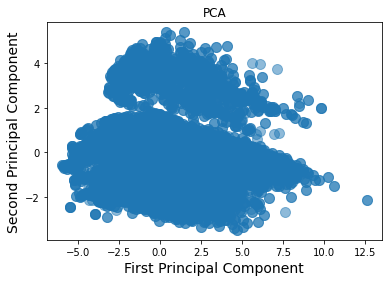

In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
X = np.array(clean_data[['isdiffpos','magpsf','mjd','magpsf_corr','sigmapsf','sigmapsf_corr','fid','sigmapsf']])
# 'objectId','classALeRCE'
y = np.array(clean_data['classALeRCE'])
# Standardizing the features
x = StandardScaler().fit_transform(X)


from sklearn.decomposition import PCA
pca = PCA()

arreglo = pca.fit_transform(x)
df = pd.DataFrame(arreglo)
#df[0]=df[0]-np.mean(df[0])
#df[1]=df[1]-np.mean(df[1])
print(df)

fig = plt.figure()
plt.title('PCA')
fig.patch.set_facecolor('white')
plt.scatter(df[0], df[1],s=100,alpha=0.5)
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)

## fid = {1 2} Indica la banda a la que corresponde (green, red)

In [ ]:
clean_data.set_index("objectId", inplace = True)
clean_data

,classALeRCE,isdiffpos,magpsf,mjd,magpsf_corr,sigmapsf,sigmapsf_corr,fid,sigmapsf
objectId,,,,,,,,,
ZTF19acyogrm,SNIbc,1.0,18.949500,58839.130984,18.810375,0.217732,0.190439,1,0.217732
ZTF19acyogrm,SNIbc,1.0,21.143200,58876.150220,20.373898,0.407393,0.180825,1,0.407393
ZTF19acyogrm,SNIbc,1.0,20.490700,58862.138264,20.004205,0.204389,0.115048,1,0.204389
ZTF19acyogrm,SNIbc,1.0,20.365100,58871.175810,19.922308,0.226880,0.139607,1,0.226880
ZTF19acyogrm,SNIbc,1.0,21.167200,58876.150220,20.385649,0.417040,0.183085,1,0.417040
...,...,...,...,...,...,...,...,...,...
ZTF19abiietd,SNII,1.0,15.788478,58737.173403,15.249795,0.024005,100.000000,2,0.024005
ZTF19abiietd,SNII,1.0,16.821075,58768.118877,15.757745,0.046151,100.000000,2,0.046151
ZTF19abiietd,SNII,1.0,16.299719,58749.111806,15.531676,0.034687,100.000000,2,0.034687


In [ ]:


# detections_df has missing columns: SupernovaeDetectionFeatureExtractor requires ('isdiffpos', 'magnitude', 'time', 'band')
# magnitude -> magpsf 
# time -> mjd
# fid -> band
#Le cambiamos los nombres a las columnas correspondientes pues este extractor necesita de estas columnas para funcionar
detections_df= clean_data.rename(columns={'magpsf':'magnitude','mjd':'time', 'fid':'band'})

feature_extractor = SupernovaeDetectionFeatureExtractor(bands=(1, 2))
features = feature_extractor.compute_features(detections = detections_df)

In [ ]:
features

,delta_mag_fid_1,delta_mjd_fid_1,first_mag_1,mean_mag_1,min_mag_1,n_det_1,n_neg_1,n_pos_1,positive_fraction_1,delta_mag_fid_2,delta_mjd_fid_2,first_mag_2,mean_mag_2,min_mag_2,n_det_2,n_neg_2,n_pos_2,positive_fraction_2
oid,,,,,,,,,,,,,,,,,,
ZTF17aadlxmv,2.244800,42.055613,19.879980,19.087656,17.947500,18.0,0.0,18.0,1.0,1.847730,48.854525,19.799040,18.540755,17.951310,36.0,0.0,36.0,1.0
ZTF18aaaqexr,0.896138,18.870671,19.133900,18.977915,18.447520,9.0,0.0,9.0,1.0,0.191736,10.058981,18.633383,18.729251,18.633383,2.0,0.0,2.0,1.0
ZTF18aacdbzx,0.495977,19.991725,19.741877,19.620142,19.432064,14.0,0.0,14.0,1.0,0.786995,27.982234,19.321800,19.284748,19.027960,20.0,0.0,20.0,1.0
ZTF18aadmssd,3.293953,59.951100,16.887047,18.581230,16.887047,16.0,0.0,16.0,1.0,2.170098,76.909931,16.508772,17.551116,16.508772,30.0,0.0,30.0,1.0
ZTF18aadzfso,1.371363,32.999224,19.840900,19.273643,18.476837,24.0,0.0,24.0,1.0,0.797367,36.979248,19.220867,18.851365,18.423500,30.0,0.0,30.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20abgbiet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,19.318298,19.318298,19.318298,1.0,0.0,1.0,1.0
ZTF20abgbvgl,1.453450,15.060695,18.730450,19.464434,18.730450,3.0,0.0,3.0,1.0,1.948065,38.989167,18.676628,19.600524,18.676628,16.0,0.0,16.0,1.0
ZTF20abgbxfm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.216758,69.925914,18.943254,19.473000,18.398882,74.0,0.0,74.0,1.0


In [ ]:
# FALTA POR ARREGLAR

# Atributos requeridos para ocupar el segundo extractor de caracteristicas: SNParametricModelExtractor
# "diff_flux", "diff_err", "time", "band", "magnitude"
# Falta comporbar que efectivamente el dataframe detections_df2 cuente con esas columnas
detections_df2= clean_data.rename(columns={'mjd':'time', 'fid':'band'})

feature_extractor2 = SNParametricModelExtractor(bands=(1, 2))
features2 = feature_extractor2.compute_features(detections = detections_df2)


In [ ]:

detections_df3 = clean_data.rename(columns={'magpsf':'magnitude','mjd':'time', 'fid':'band'})

feature_extractor3 = IQRExtractor(bands=(1, 2))
features3 = feature_extractor3.compute_features(detections = detections_df3)
features3

,iqr_1,iqr_2
oid,,
ZTF17aadlxmv,0.946885,0.657760
ZTF18aaaqexr,0.487402,0.095868
ZTF18aacdbzx,0.268495,0.257782
ZTF18aadmssd,1.525995,0.901432
ZTF18aadzfso,0.784556,0.338915
...,...,...
ZTF20abgbiet,NaN,0.000000
ZTF20abgbvgl,0.726725,0.823273
ZTF20abgbxfm,NaN,1.189646


In [ ]:
clean_data

,classALeRCE,isdiffpos,magpsf,mjd,magpsf_corr,sigmapsf,sigmapsf_corr,fid,sigmapsf
objectId,,,,,,,,,
ZTF19acyogrm,SNIbc,1.0,18.949500,58839.130984,18.810375,0.217732,0.190439,1,0.217732
ZTF19acyogrm,SNIbc,1.0,21.143200,58876.150220,20.373898,0.407393,0.180825,1,0.407393
ZTF19acyogrm,SNIbc,1.0,20.490700,58862.138264,20.004205,0.204389,0.115048,1,0.204389
ZTF19acyogrm,SNIbc,1.0,20.365100,58871.175810,19.922308,0.226880,0.139607,1,0.226880
ZTF19acyogrm,SNIbc,1.0,21.167200,58876.150220,20.385649,0.417040,0.183085,1,0.417040
...,...,...,...,...,...,...,...,...,...
ZTF19abiietd,SNII,1.0,15.788478,58737.173403,15.249795,0.024005,100.000000,2,0.024005
ZTF19abiietd,SNII,1.0,16.821075,58768.118877,15.757745,0.046151,100.000000,2,0.046151
ZTF19abiietd,SNII,1.0,16.299719,58749.111806,15.531676,0.034687,100.000000,2,0.034687


# Veamos la matriz de correlación, para ver que tan relacionados estan los datos

In [ ]:
df = features.join(features3)
df

,delta_mag_fid_1,delta_mjd_fid_1,first_mag_1,mean_mag_1,min_mag_1,n_det_1,n_neg_1,n_pos_1,positive_fraction_1,delta_mag_fid_2,delta_mjd_fid_2,first_mag_2,mean_mag_2,min_mag_2,n_det_2,n_neg_2,n_pos_2,positive_fraction_2,iqr_1,iqr_2
oid,,,,,,,,,,,,,,,,,,,,
ZTF17aadlxmv,2.244800,42.055613,19.879980,19.087656,17.947500,18.0,0.0,18.0,1.0,1.847730,48.854525,19.799040,18.540755,17.951310,36.0,0.0,36.0,1.0,0.946885,0.657760
ZTF18aaaqexr,0.896138,18.870671,19.133900,18.977915,18.447520,9.0,0.0,9.0,1.0,0.191736,10.058981,18.633383,18.729251,18.633383,2.0,0.0,2.0,1.0,0.487402,0.095868
ZTF18aacdbzx,0.495977,19.991725,19.741877,19.620142,19.432064,14.0,0.0,14.0,1.0,0.786995,27.982234,19.321800,19.284748,19.027960,20.0,0.0,20.0,1.0,0.268495,0.257782
ZTF18aadmssd,3.293953,59.951100,16.887047,18.581230,16.887047,16.0,0.0,16.0,1.0,2.170098,76.909931,16.508772,17.551116,16.508772,30.0,0.0,30.0,1.0,1.525995,0.901432
ZTF18aadzfso,1.371363,32.999224,19.840900,19.273643,18.476837,24.0,0.0,24.0,1.0,0.797367,36.979248,19.220867,18.851365,18.423500,30.0,0.0,30.0,1.0,0.784556,0.338915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20abgbiet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,19.318298,19.318298,19.318298,1.0,0.0,1.0,1.0,NaN,0.000000
ZTF20abgbvgl,1.453450,15.060695,18.730450,19.464434,18.730450,3.0,0.0,3.0,1.0,1.948065,38.989167,18.676628,19.600524,18.676628,16.0,0.0,16.0,1.0,0.726725,0.823273
ZTF20abgbxfm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.216758,69.925914,18.943254,19.473000,18.398882,74.0,0.0,74.0,1.0,NaN,1.189646


In [ ]:
print(df.shape)
print(df.columns.values)

(1162, 20)
['delta_mag_fid_1' 'delta_mjd_fid_1' 'first_mag_1' 'mean_mag_1'
 'min_mag_1' 'n_det_1' 'n_neg_1' 'n_pos_1' 'positive_fraction_1'
 'delta_mag_fid_2' 'delta_mjd_fid_2' 'first_mag_2' 'mean_mag_2'
 'min_mag_2' 'n_det_2' 'n_neg_2' 'n_pos_2' 'positive_fraction_2' 'iqr_1'
 'iqr_2']


In [ ]:
df = df.reset_index()
df


,oid,delta_mag_fid_1,delta_mjd_fid_1,first_mag_1,mean_mag_1,min_mag_1,n_det_1,n_neg_1,n_pos_1,positive_fraction_1,delta_mag_fid_2,delta_mjd_fid_2,first_mag_2,mean_mag_2,min_mag_2,n_det_2,n_neg_2,n_pos_2,positive_fraction_2,iqr_1,iqr_2
0,ZTF17aadlxmv,2.244800,42.055613,19.879980,19.087656,17.947500,18.0,0.0,18.0,1.0,1.847730,48.854525,19.799040,18.540755,17.951310,36.0,0.0,36.0,1.0,0.946885,0.657760
1,ZTF18aaaqexr,0.896138,18.870671,19.133900,18.977915,18.447520,9.0,0.0,9.0,1.0,0.191736,10.058981,18.633383,18.729251,18.633383,2.0,0.0,2.0,1.0,0.487402,0.095868
2,ZTF18aacdbzx,0.495977,19.991725,19.741877,19.620142,19.432064,14.0,0.0,14.0,1.0,0.786995,27.982234,19.321800,19.284748,19.027960,20.0,0.0,20.0,1.0,0.268495,0.257782
3,ZTF18aadmssd,3.293953,59.951100,16.887047,18.581230,16.887047,16.0,0.0,16.0,1.0,2.170098,76.909931,16.508772,17.551116,16.508772,30.0,0.0,30.0,1.0,1.525995,0.901432
4,ZTF18aadzfso,1.371363,32.999224,19.840900,19.273643,18.476837,24.0,0.0,24.0,1.0,0.797367,36.979248,19.220867,18.851365,18.423500,30.0,0.0,30.0,1.0,0.784556,0.338915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157,ZTF20abgbiet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,19.318298,19.318298,19.318298,1.0,0.0,1.0,1.0,NaN,0.000000
1158,ZTF20abgbvgl,1.453450,15.060695,18.730450,19.464434,18.730450,3.0,0.0,3.0,1.0,1.948065,38.989167,18.676628,19.600524,18.676628,16.0,0.0,16.0,1.0,0.726725,0.823273
1159,ZTF20abgbxfm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.216758,69.925914,18.943254,19.473000,18.398882,74.0,0.0,74.0,1.0,NaN,1.189646
1160,ZTF20abgfekk,1.627867,31.928044,19.095242,17.742374,17.467375,32.0,0.0,32.0,1.0,1.534458,31.981505,19.148731,17.866029,17.614273,40.0,0.0,40.0,1.0,0.298659,0.155161


In [ ]:
dfcrossmatches

,oid,classALeRCE,ra,dec,period,source,id_source,class_source,separation_arcsec
0,ZTF19abegncu,AGN,357.296363,-8.941186,NaN,Oh2015,5.8772718059579e+17,AGN_galaxy_dominated,0.243081
1,ZTF18acejdhu,AGN,11.958444,-10.496615,NaN,Oh2015,5.877272256953059e+17,AGN_galaxy_dominated,0.301126
2,ZTF18acdzene,AGN,17.478620,-10.110250,NaN,Oh2015,5.877271789938934e+17,AGN_galaxy_dominated,0.158643
3,ZTF18abwzuzw,AGN,25.038255,-10.352430,NaN,Oh2015,5.877272294485526e+17,AGN_galaxy_dominated,0.485322
4,ZTF19abmposz,AGN,26.670031,-8.354787,NaN,Oh2015,5.877271806085038e+17,AGN_galaxy_dominated,0.213990
...,...,...,...,...,...,...,...,...,...
173874,ZTF18abikbvc,LPV,286.720222,24.733440,NaN,GAIADR2VS,4.533629080944307e+18,MIRA_SR,0.299487
173875,ZTF19aamtoyb,LPV,99.257590,-15.567786,NaN,GAIADR2VS,2.9501070744892713e+18,MIRA_SR,0.299597
173876,ZTF19abeesgk,LPV,277.499222,-27.002742,NaN,GAIADR2VS,4.0518162825206625e+18,MIRA_SR,0.299766
173877,ZTF18abnubuy,LPV,292.053754,38.418277,NaN,GAIADR2VS,2.0526959231045647e+18,MIRA_SR,0.299777


# Matriz de covarianza:
Nos permite visualizar de forma gráfica que tan correlacionados estan las caracteristicas extraidas por los extractores.

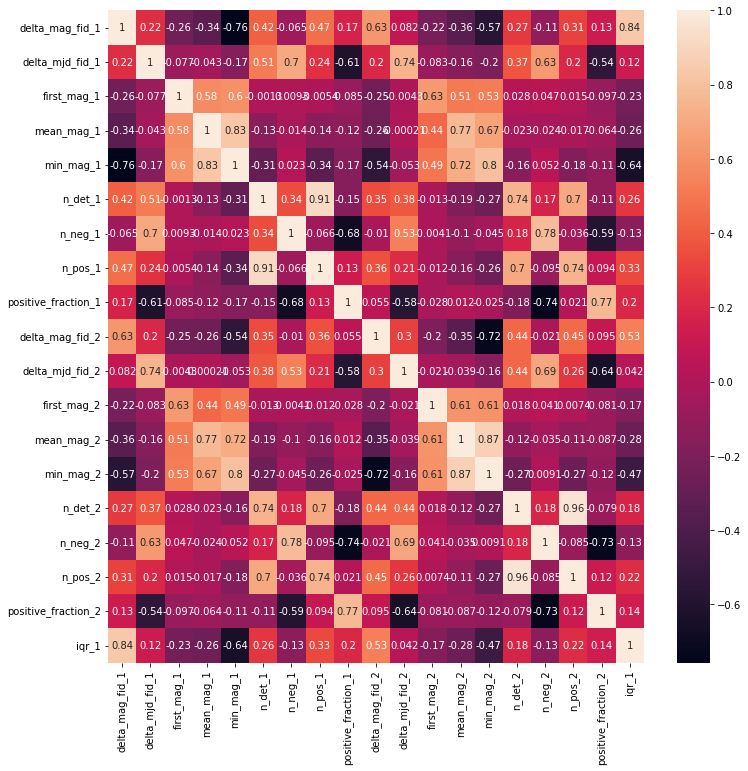

In [ ]:
import seaborn as sns

# taking all rows but only 6 columns
df_small = df.iloc[:,1:20]

correlation_mat = df_small.corr()

plt.figure(figsize=(12,12))
sns.heatmap(correlation_mat, annot = True)

plt.show()

In [ ]:
from sklearn.utils import shuffle

df_con_target = pd.merge(df, dfcrossmatches[['oid','classALeRCE']])
df_con_target

,oid,delta_mag_fid_1,delta_mjd_fid_1,first_mag_1,mean_mag_1,min_mag_1,n_det_1,n_neg_1,n_pos_1,positive_fraction_1,delta_mag_fid_2,delta_mjd_fid_2,first_mag_2,mean_mag_2,min_mag_2,n_det_2,n_neg_2,n_pos_2,positive_fraction_2,iqr_1,iqr_2,classALeRCE
0,ZTF17aadlxmv,2.244800,42.055613,19.879980,19.087656,17.947500,18.0,0.0,18.0,1.0,1.847730,48.854525,19.799040,18.540755,17.951310,36.0,0.0,36.0,1.0,0.946885,0.657760,SNIa
1,ZTF18aaaqexr,0.896138,18.870671,19.133900,18.977915,18.447520,9.0,0.0,9.0,1.0,0.191736,10.058981,18.633383,18.729251,18.633383,2.0,0.0,2.0,1.0,0.487402,0.095868,SNIa
2,ZTF18aacdbzx,0.495977,19.991725,19.741877,19.620142,19.432064,14.0,0.0,14.0,1.0,0.786995,27.982234,19.321800,19.284748,19.027960,20.0,0.0,20.0,1.0,0.268495,0.257782,SNIbc
3,ZTF18aadmssd,3.293953,59.951100,16.887047,18.581230,16.887047,16.0,0.0,16.0,1.0,2.170098,76.909931,16.508772,17.551116,16.508772,30.0,0.0,30.0,1.0,1.525995,0.901432,SNIIn
4,ZTF18aadzfso,1.371363,32.999224,19.840900,19.273643,18.476837,24.0,0.0,24.0,1.0,0.797367,36.979248,19.220867,18.851365,18.423500,30.0,0.0,30.0,1.0,0.784556,0.338915,SNIa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157,ZTF20abgbiet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,19.318298,19.318298,19.318298,1.0,0.0,1.0,1.0,NaN,0.000000,SNIa
1158,ZTF20abgbvgl,1.453450,15.060695,18.730450,19.464434,18.730450,3.0,0.0,3.0,1.0,1.948065,38.989167,18.676628,19.600524,18.676628,16.0,0.0,16.0,1.0,0.726725,0.823273,SNIa
1159,ZTF20abgbxfm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.216758,69.925914,18.943254,19.473000,18.398882,74.0,0.0,74.0,1.0,NaN,1.189646,SNIa
1160,ZTF20abgfekk,1.627867,31.928044,19.095242,17.742374,17.467375,32.0,0.0,32.0,1.0,1.534458,31.981505,19.148731,17.866029,17.614273,40.0,0.0,40.0,1.0,0.298659,0.155161,SNIa


In [ ]:
df_shuffle = shuffle(df_con_target)
df_shuffle = df_shuffle.dropna()
df_shuffle

,oid,delta_mag_fid_1,delta_mjd_fid_1,first_mag_1,mean_mag_1,min_mag_1,n_det_1,n_neg_1,n_pos_1,positive_fraction_1,delta_mag_fid_2,delta_mjd_fid_2,first_mag_2,mean_mag_2,min_mag_2,n_det_2,n_neg_2,n_pos_2,positive_fraction_2,iqr_1,iqr_2,classALeRCE
228,ZTF18acmyxfx,2.172800,51.763044,19.300941,19.629768,18.754700,5.0,0.0,5.0,1.000000,1.480621,55.918623,19.918394,19.211332,18.458979,11.0,0.0,11.0,1.00,0.783500,1.043346,SNIa
841,ZTF19acshkft,2.340500,45.921945,18.858100,19.144054,18.418700,22.0,0.0,22.0,1.000000,1.357200,52.852326,19.806500,19.157570,18.449300,18.0,0.0,18.0,1.00,1.217481,0.831800,SNIa
365,ZTF19aallvor,2.205800,410.995752,18.928453,19.736269,18.493900,12.0,2.0,10.0,0.833333,0.983801,418.916400,18.948725,19.521612,18.948725,16.0,4.0,12.0,0.75,1.674247,0.509100,SNIa
1104,ZTF20aazooyu,2.262858,40.941701,19.163776,19.326323,18.532442,56.0,0.0,56.0,1.000000,1.600800,47.834468,19.585762,19.194577,18.606200,60.0,0.0,60.0,1.00,1.131305,0.681417,SNIa
877,ZTF19adbricc,0.731838,21.143692,18.819141,18.615345,18.317726,20.0,0.0,20.0,1.000000,2.042172,48.861157,18.659689,19.202169,18.543130,52.0,0.0,52.0,1.00,0.363378,0.749466,SNIa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,ZTF20aaifyfx,1.904694,18.023032,18.269700,18.983079,18.243406,12.0,0.0,12.0,1.000000,0.914806,24.988704,18.110899,18.611986,18.110899,14.0,0.0,14.0,1.00,1.225787,0.596395,SNIa
277,ZTF18acvwbos,3.361338,106.892697,17.431162,19.144818,17.431162,50.0,0.0,50.0,1.000000,3.037385,109.889618,17.637154,18.322768,17.086164,56.0,0.0,56.0,1.00,1.872380,1.548749,SNIa
851,ZTF19acxolhu,2.237520,42.806620,18.568280,19.473112,18.568280,5.0,0.0,5.0,1.000000,1.366985,48.876447,18.862198,19.311841,18.746006,11.0,0.0,11.0,1.00,1.148287,0.828547,SNIa
811,ZTF19acihlft,3.736373,47.896933,19.108986,16.561395,15.372613,6.0,0.0,6.0,1.000000,3.645852,29.908357,19.155579,16.947217,15.509727,5.0,0.0,5.0,1.00,1.801435,1.385328,SNIa


# Separación del conjunto en entrenamiento y test: 
Dividiremos el conjunto en 70% para entrenamiento y 30% para test

In [ ]:

rows= 755 

train = df_shuffle.iloc[0:int(rows*0.7)]
train

,oid,delta_mag_fid_1,delta_mjd_fid_1,first_mag_1,mean_mag_1,min_mag_1,n_det_1,n_neg_1,n_pos_1,positive_fraction_1,delta_mag_fid_2,delta_mjd_fid_2,first_mag_2,mean_mag_2,min_mag_2,n_det_2,n_neg_2,n_pos_2,positive_fraction_2,iqr_1,iqr_2,classALeRCE
228,ZTF18acmyxfx,2.172800,51.763044,19.300941,19.629768,18.754700,5.0,0.0,5.0,1.000000,1.480621,55.918623,19.918394,19.211332,18.458979,11.0,0.0,11.0,1.00,0.783500,1.043346,SNIa
841,ZTF19acshkft,2.340500,45.921945,18.858100,19.144054,18.418700,22.0,0.0,22.0,1.000000,1.357200,52.852326,19.806500,19.157570,18.449300,18.0,0.0,18.0,1.00,1.217481,0.831800,SNIa
365,ZTF19aallvor,2.205800,410.995752,18.928453,19.736269,18.493900,12.0,2.0,10.0,0.833333,0.983801,418.916400,18.948725,19.521612,18.948725,16.0,4.0,12.0,0.75,1.674247,0.509100,SNIa
1104,ZTF20aazooyu,2.262858,40.941701,19.163776,19.326323,18.532442,56.0,0.0,56.0,1.000000,1.600800,47.834468,19.585762,19.194577,18.606200,60.0,0.0,60.0,1.00,1.131305,0.681417,SNIa
877,ZTF19adbricc,0.731838,21.143692,18.819141,18.615345,18.317726,20.0,0.0,20.0,1.000000,2.042172,48.861157,18.659689,19.202169,18.543130,52.0,0.0,52.0,1.00,0.363378,0.749466,SNIa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,ZTF19abhpvfq,0.476573,8.927349,17.899353,17.661067,17.422780,2.0,0.0,2.0,1.000000,0.000000,0.000000,18.117880,18.117880,18.117880,1.0,0.0,1.0,1.00,0.238287,0.000000,SNIa
92,ZTF18abespgb,0.866045,10.009097,18.577085,19.074140,18.577085,3.0,0.0,3.0,1.000000,1.406300,31.030104,19.599888,18.833046,18.193588,6.0,0.0,6.0,1.00,0.433022,0.499561,SNIa
296,ZTF18adalarn,2.377190,34.918299,19.924100,18.317180,17.546910,20.0,0.0,20.0,1.000000,2.180073,37.933761,19.468464,17.955339,17.288391,22.0,0.0,22.0,1.00,1.369599,1.061771,SNIa
448,ZTF19aaqyvdn,1.679124,19.059849,18.536976,19.223824,18.536976,4.0,0.0,4.0,1.000000,1.767865,43.961574,18.295435,19.158465,18.295435,10.0,0.0,10.0,1.00,0.776187,1.123845,SNIa


In [ ]:
test = df_shuffle.iloc[int(rows*0.7):rows]
test

,oid,delta_mag_fid_1,delta_mjd_fid_1,first_mag_1,mean_mag_1,min_mag_1,n_det_1,n_neg_1,n_pos_1,positive_fraction_1,delta_mag_fid_2,delta_mjd_fid_2,first_mag_2,mean_mag_2,min_mag_2,n_det_2,n_neg_2,n_pos_2,positive_fraction_2,iqr_1,iqr_2,classALeRCE
254,ZTF18acrlmvt,1.177077,32.747558,18.859200,18.946675,18.531523,12.0,0.0,12.0,1.0,1.839455,72.835035,19.212305,18.806486,18.298874,44.0,0.0,44.0,1.0,0.765265,0.781109,SNIa
837,ZTF19acpgaet,1.044185,21.995231,18.834938,18.914777,18.603642,16.0,0.0,16.0,1.0,1.808283,21.860428,20.345200,19.168794,18.536917,10.0,0.0,10.0,1.0,0.282493,0.897322,SNIa
706,ZTF19abtsrup,3.153766,89.844502,18.985832,18.339263,16.959944,50.0,0.0,50.0,1.0,2.517236,80.814618,17.963451,18.168084,17.054964,38.0,0.0,38.0,1.0,1.959494,1.228669,SNIa
1128,ZTF20abbrptu,3.718217,48.012558,20.845000,18.254811,17.126783,24.0,0.0,24.0,1.0,3.257192,47.947303,20.529500,18.143222,17.272308,24.0,0.0,24.0,1.0,1.172668,0.655630,SNIa
191,ZTF18acbwavp,0.380428,3.020984,19.320618,19.510832,19.320618,2.0,0.0,2.0,1.0,0.623349,10.884317,19.013248,19.400338,19.013248,3.0,0.0,3.0,1.0,0.190214,0.311675,SNIa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,ZTF20aaifyfx,1.904694,18.023032,18.269700,18.983079,18.243406,12.0,0.0,12.0,1.0,0.914806,24.988704,18.110899,18.611986,18.110899,14.0,0.0,14.0,1.0,1.225787,0.596395,SNIa
277,ZTF18acvwbos,3.361338,106.892697,17.431162,19.144818,17.431162,50.0,0.0,50.0,1.0,3.037385,109.889618,17.637154,18.322768,17.086164,56.0,0.0,56.0,1.0,1.872380,1.548749,SNIa
851,ZTF19acxolhu,2.237520,42.806620,18.568280,19.473112,18.568280,5.0,0.0,5.0,1.0,1.366985,48.876447,18.862198,19.311841,18.746006,11.0,0.0,11.0,1.0,1.148287,0.828547,SNIa
811,ZTF19acihlft,3.736373,47.896933,19.108986,16.561395,15.372613,6.0,0.0,6.0,1.0,3.645852,29.908357,19.155579,16.947217,15.509727,5.0,0.0,5.0,1.0,1.801435,1.385328,SNIa


In [ ]:
target = np.array(train['classALeRCE'])
print(target.shape)

(528,)


In [ ]:
train_sin_target = train.iloc[:,1:20]
print(train_sin_target.head())
data = train_sin_target.to_numpy()
print(data.shape)

      delta_mag_fid_1  delta_mjd_fid_1  ...  positive_fraction_2     iqr_1
228          2.172800        51.763044  ...                 1.00  0.783500
841          2.340500        45.921945  ...                 1.00  1.217481
365          2.205800       410.995752  ...                 0.75  1.674247
1104         2.262858        40.941701  ...                 1.00  1.131305
877          0.731838        21.143692  ...                 1.00  0.363378

[5 rows x 19 columns]
(528, 19)


Ejemplo uso Pca antes de la clasificacion

In [ ]:
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris


# initiate PCA and classifier
pca = PCA()
classifier = DecisionTreeClassifier()

# transform / fit

X_transformed = pca.fit_transform(data)
classifier.fit(X_transformed, target)


DecisionTreeClassifier()

In [ ]:
# predict new data:
test_sin_target = test.iloc[:,1:20]
#pues solo usaremos el target para comprobar la eficacia de la predicción
newdata = test_sin_target.to_numpy()


# transform new data using already fitted pca
# (don't re-fit the pca)
newdata_transformed = pca.transform(newdata)

# predict labels using the trained classifier

pred_labels = classifier.predict(newdata_transformed)

In [ ]:
pred_labels_df = pd.DataFrame(pred_labels,columns=['pred_labels']) 
pred_labels_df

,pred_labels
0,SNIa
1,SNIa
2,SNIa
3,SNIIn
4,SNIbc
...,...
222,SNIa
223,SNII
224,SNIa
225,SNIIn


In [ ]:
pred_labels_df.index = list(test["oid"])
pred_labels_df = pred_labels_df.reset_index()
pred_labels_df_n  = pred_labels_df .rename(columns={'index':'oid'})
pred_labels_df_n

,oid,pred_labels
0,ZTF18acrlmvt,SNIa
1,ZTF19acpgaet,SNIa
2,ZTF19abtsrup,SNIa
3,ZTF20abbrptu,SNIIn
4,ZTF18acbwavp,SNIbc
...,...,...
222,ZTF20aaifyfx,SNIa
223,ZTF18acvwbos,SNII
224,ZTF19acxolhu,SNIa
225,ZTF19acihlft,SNIIn


In [ ]:
comparacion_resultados = pd.merge(pred_labels_df_n, dfcrossmatches[['oid','classALeRCE']], left_on='oid', right_on='oid')
comparacion_resultados

,oid,pred_labels,classALeRCE
0,ZTF18acrlmvt,SNIa,SNIa
1,ZTF19acpgaet,SNIa,SNIa
2,ZTF19abtsrup,SNIa,SNIa
3,ZTF20abbrptu,SNIIn,SNIa
4,ZTF18acbwavp,SNIbc,SNIa
...,...,...,...
222,ZTF20aaifyfx,SNIa,SNIa
223,ZTF18acvwbos,SNII,SNIa
224,ZTF19acxolhu,SNIa,SNIa
225,ZTF19acihlft,SNIIn,SNIa


In [ ]:
iguales = sum([comparacion_resultados['pred_labels']==comparacion_resultados['classALeRCE']])
iguales

0      1
1      1
2      1
3      0
4      0
      ..
222    1
223    0
224    1
225    0
226    1
Length: 227, dtype: int64

In [ ]:
print(f'N° de aciertos: {iguales.sum()}, N° de errores: {227-iguales.sum()}')

N° de aciertos: 169, N° de errores: 58


# Resultados
Primer experimento: N° de aciertos: 169, N° de errores: 58

Text(0, 0.5, 'Second Principal Component')

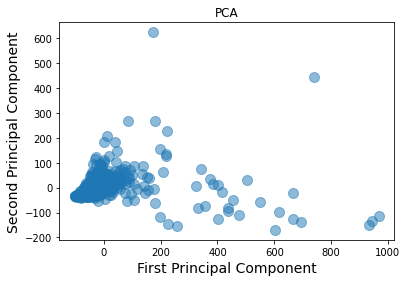

In [ ]:

graficar_pca = pd.DataFrame(X_transformed )
fig1 = plt.figure()
plt.title('PCA')
fig1.patch.set_facecolor('white')
plt.scatter(graficar_pca[0], graficar_pca[1],s=100,alpha=0.5)
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)

